In [35]:
from pathlib import Path

import matplotlib.pyplot as plt
import torch
import torchinfo
import torchvision
from torch.utils.data import DataLoader
from torchlake.common.constants import IMAGENET_MEAN, IMAGENET_STD
from torchlake.common.controller.evaluator import ClassificationEvaluator
from torchlake.common.controller.trainer import ClassificationTrainer
from torchlake.common.utils.convert import img_tensor_to_np
from torchlake.common.utils.platform import get_file_size, get_num_workers
from torchlake.image_classification.models import WideResNet
from torchvision import transforms

# Setting

In [36]:
IMAGE_SIZE = 224
BATCH_SIZE = 64

In [37]:
artifact_path = Path("../../artifacts/wide-resnet")
data_path = Path("../../data/animal10")

In [38]:
device = torch.device("cuda:0")

# data

In [39]:
preprocess = transforms.Compose(
    [
        transforms.RandomHorizontalFlip(),
        transforms.ColorJitter(),
        transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)),
        transforms.ToTensor(),
        transforms.Normalize(IMAGENET_MEAN, IMAGENET_STD),
    ]
)

In [40]:
dataset = torchvision.datasets.ImageFolder(
    data_path.as_posix(),
    transform=preprocess,
)

In [41]:
train_loader = DataLoader(
    dataset,
    batch_size=BATCH_SIZE,
    shuffle=True,
    drop_last=True,
    pin_memory=True,
    num_workers=get_num_workers(),
)

In [42]:
num_class = len(dataset.classes)

In [43]:
dataset.classes

['cane',
 'cavallo',
 'elefante',
 'farfalla',
 'gallina',
 'gatto',
 'mucca',
 'pecora',
 'ragno',
 'scoiattolo']

In [44]:
len(dataset)

26179

farfalla


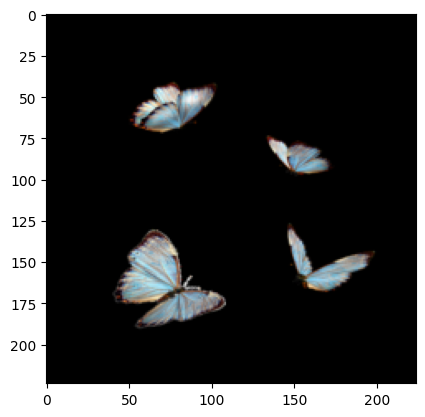

In [45]:
import random
demo_img, demo_label = dataset[random.randint(0, len(dataset))]
print(dataset.classes[demo_label])
plt.imshow((img_tensor_to_np(demo_img) * IMAGENET_STD + IMAGENET_MEAN).clip(0, 1))

# model

In [46]:
# WRN-16-8
model = WideResNet(
    output_size=num_class,
    deepening_factor=3,
    widening_factor=8,
    enable_dropout=False,
).to(device)

In [47]:
torchinfo.summary(model)

Layer (type:depth-idx)                             Param #
WideResNet                                         --
├─Sequential: 1-1                                  --
│    └─Conv2dNormActivation: 2-1                   --
│    │    └─Conv2d: 3-1                            2,352
│    │    └─BatchNorm2d: 3-2                       32
│    │    └─ReLU: 3-3                              --
│    └─MaxPool2d: 2-2                              --
├─Sequential: 1-2                                  --
│    └─ResBlock: 2-3                               --
│    │    └─ReLU: 3-4                              --
│    │    └─DropoutConvBlock: 3-5                  4,672
│    │    └─Sequential: 3-6                        288
├─Sequential: 1-3                                  --
│    └─ResBlock: 2-4                               --
│    │    └─ReLU: 3-7                              --
│    │    └─DropoutConvBlock: 3-8                  13,920
│    │    └─Sequential: 3-9                        576
├─Sequentia

# training

In [48]:
epoches = 10
acc_iters = 64 // BATCH_SIZE

In [49]:
trainer = ClassificationTrainer(epoches, device, acc_iters)

In [50]:
criterion = trainer.get_criterion(num_class)
optim = torch.optim.Adam(model.parameters(), weight_decay=1e-5)

In [51]:
training_loss = trainer.run(train_loader, model, optim, criterion)

100%|██████████| 1636/1636 [02:03<00:00, 13.27it/s]


epoch 1 : 0.027645943476875427


100%|██████████| 1636/1636 [02:03<00:00, 13.30it/s]


epoch 2 : 0.02146590696670534


100%|██████████| 1636/1636 [02:02<00:00, 13.40it/s]


epoch 3 : 0.01868499347639514


100%|██████████| 1636/1636 [02:03<00:00, 13.30it/s]


epoch 4 : 0.016903525793897603


100%|██████████| 1636/1636 [02:04<00:00, 13.15it/s]


epoch 5 : 0.015890128524577777


100%|██████████| 1636/1636 [02:03<00:00, 13.28it/s]


epoch 6 : 0.01498685948238173


100%|██████████| 1636/1636 [02:04<00:00, 13.13it/s]


epoch 7 : 0.014184752416576107


100%|██████████| 1636/1636 [02:02<00:00, 13.36it/s]


epoch 8 : 0.013464408036615144


100%|██████████| 1636/1636 [01:59<00:00, 13.68it/s]


epoch 9 : 0.01282795872123716


100%|██████████| 1636/1636 [02:06<00:00, 12.93it/s]

epoch 10 : 0.01240900227635493


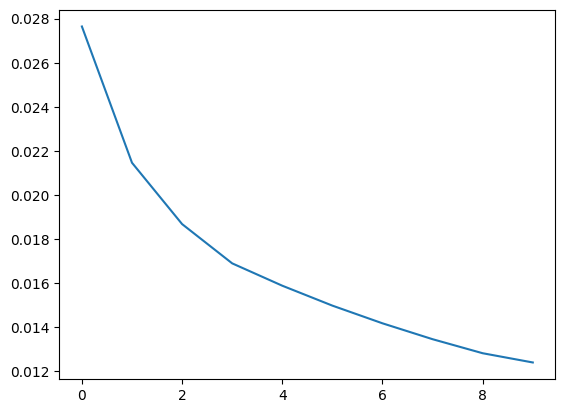

In [52]:
plt.plot(training_loss)

# inference

In [53]:
test_preprocess = transforms.Compose(
    [
        transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)),
        transforms.ToTensor(),
        transforms.Normalize(IMAGENET_MEAN, IMAGENET_STD),
    ]
)

In [54]:
test_dataset = torchvision.datasets.ImageFolder(
    data_path.as_posix(),
    transform=test_preprocess,
)

In [55]:
test_loader = DataLoader(
    test_dataset,
    batch_size=BATCH_SIZE,
    pin_memory=True,
    num_workers=get_num_workers(),
)

In [56]:
evaluator = ClassificationEvaluator(num_class, device)

In [57]:
confusion_matrix = evaluator.run(test_loader, model)

100%|██████████| 1637/1637 [01:47<00:00, 15.19it/s]

[[3979  104   49   35   84  179   80   89  194   70]
 [ 291 1728   57   20   44   16  313   92   45   17]
 [ 105   30 1091    4   37   11   62   52   27   27]
 [  36    3    1 1779   26   12    5    3  220   27]
 [ 173   14    5   80 2623   23   15   38   96   31]
 [ 467    5   14   20   26  873    4   17  155   87]
 [ 207  118   45    3   31    1 1250  179   24    8]
 [ 168   28   44    3   55   23  152 1265   48   34]
 [  58    7    7  151   34   29    6   12 4453   64]
 [ 171    6   11   30   95   88    4   25  177 1255]]


In [58]:
per_class_acc = evaluator.get_per_class_accuracy(confusion_matrix)
evaluator.show_per_class_accuracy(test_dataset.classes, per_class_acc)

cane      : 0.8182192062512852
cavallo   : 0.658787647731605
elefante  : 0.7544951590594744
farfalla  : 0.8423295454545454
gallina   : 0.8466752743705617
gatto     : 0.5233812949640287
mucca     : 0.669882100750268
pecora    : 0.695054945054945
ragno     : 0.9236672889442025
scoiattolo: 0.6740064446831364


In [59]:
per_class_acc.mean()

0.7406498907264053

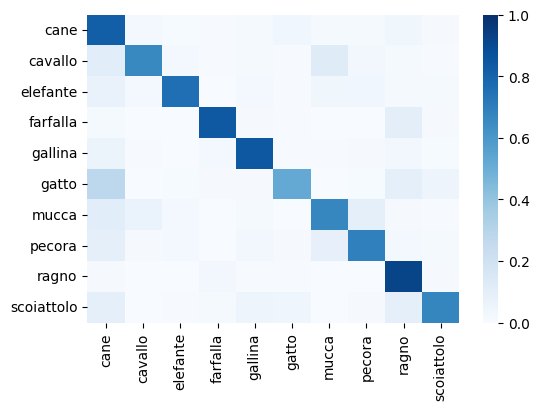

In [60]:
evaluator.plot_confusion_matrix(
    confusion_matrix,
    test_dataset.classes,
    "Blues",
    annot=False,
    figsize=(6, 4),
)

In [61]:
model_path = artifact_path / f'wrn-{model.deepening_factor * 6 + 4}-{model.widening_factor}-dropout-{model.enable_dropout}.pth'

In [62]:
torch.save(model.state_dict(), model_path)

In [63]:
get_file_size(model_path)

'0.33MB'

In [64]:
model.load_state_dict(torch.load(model_path.as_posix()))

<All keys matched successfully>